In [1]:
import numpy as np
import matplotlib.pyplot as plt
import librosa
import librosa.display
from tensorflow.keras.utils import to_categorical

# Load the raw files you created in Part 1
print("Loading raw acoustic data...")
X_raw = np.load('X_raw_subset.npy')
y_labels = np.load('y_labels_subset.npy')
print(f"Loaded {len(X_raw)} samples.")

C:\Users\saide\anaconda3\Lib\site-packages\keras\src\export\tf2onnx_lib.py:8: FutureWarning: In the future `np.object` will be defined as the corresponding NumPy scalar.
  if not hasattr(np, "object"):


Loading raw acoustic data...
Loaded 6813 samples.


In [2]:
X_images = []
print("Converting to 128x128 Mel-spectrograms...")

for i, signal in enumerate(X_raw):
    # Convert to Mel-scale and then to Decibels (Log Scale)
    mel = librosa.feature.melspectrogram(y=signal, sr=16000, n_mels=128)
    log_mel = librosa.power_to_db(mel, ref=np.max)
    
    # Crop/Resize to exactly 128x128
    X_images.append(log_mel[:, :128])

# Convert to initial numpy array
X_train = np.array(X_images)
print(f"Created image array with shape: {X_train.shape}")

Converting to 128x128 Mel-spectrograms...
Created image array with shape: (6813, 128, 126)


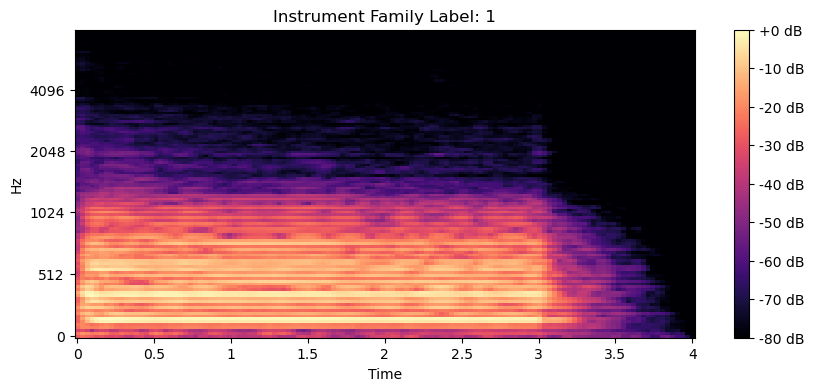

In [3]:
sample_idx = 0 
plt.figure(figsize=(10, 4))
librosa.display.specshow(X_train[sample_idx], sr=16000, x_axis='time', y_axis='mel')
plt.title(f"Instrument Family Label: {y_labels[sample_idx]}")
plt.colorbar(format='%+2.0f dB')
plt.show()

In [4]:
print("Normalizing and fixing array shapes...")

# 1. Normalize pixels between 0 and 1
X_train_norm = (X_train - X_train.min()) / (X_train.max() - X_train.min())

# 2. Use integer division to find how many 128x128 images fit perfectly
image_size = 128 * 128 * 1
num_samples = X_train_norm.size // image_size 

# 3. Trim the extra pixels and reshape to (Samples, 128, 128, 1)
X_train_final = X_train_norm.flatten()[:num_samples * image_size].reshape(num_samples, 128, 128, 1)

# 4. Synchronize and One-Hot Encode labels
y_labels_trimmed = y_labels[:num_samples]
y_train_encoded = to_categorical(y_labels_trimmed, num_classes=11)

print(f"Final Input Shape for CNN: {X_train_final.shape}") # Should be (6706, 128, 128, 1)
print(f"Final Label Shape: {y_train_encoded.shape}")

Normalizing and fixing array shapes...
Final Input Shape for CNN: (6706, 128, 128, 1)
Final Label Shape: (6706, 11)


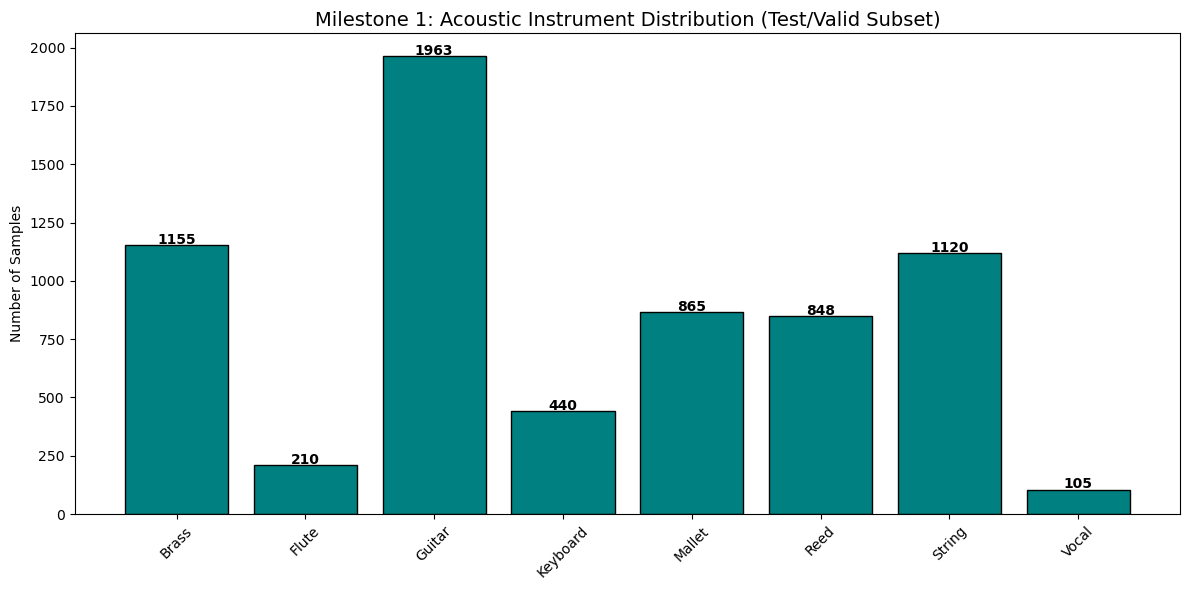

In [5]:
family_names = ['Bass', 'Brass', 'Flute', 'Guitar', 'Keyboard', 
                'Mallet', 'Organ', 'Reed', 'String', 'Synth', 'Vocal']

unique, counts = np.unique(y_labels_trimmed, return_counts=True)

plt.figure(figsize=(12, 6))
bars = plt.bar([family_names[i] for i in unique], counts, color='teal', edgecolor='black')
plt.title('Milestone 1: Acoustic Instrument Distribution (Test/Valid Subset)', fontsize=14)
plt.ylabel('Number of Samples')
plt.xticks(rotation=45)

# Add counts on top of bars
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 5, int(yval), ha='center', fontweight='bold')

plt.tight_layout()
plt.show()

In [6]:
import numpy as np
import json
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split

# Load the data you shared
X = np.load('X.npy')
y = np.load('y.npy')
with open('label_map.json', 'r') as f:
    label_map = json.load(f)

# Normalize and reshape for CNN (Samples, Height, Width, Channels)
X = X.astype('float32') / 255.0 
if len(X.shape) == 3:
    X = X.reshape(X.shape[0], X.shape[1], X.shape[2], 1)

# One-hot encode labels (11 classes for NSynth)
y_cat = to_categorical(y, num_classes=len(label_map))

# Split for Week 5-6 validation milestone
X_train, X_val, y_train, y_val = train_test_split(X, y_cat, test_size=0.2, random_state=42)

In [7]:
from tensorflow.keras import layers, models

def build_instrunet_cnn(input_shape, num_classes):
    model = models.Sequential([
        layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
        layers.MaxPooling2D((2, 2)),
        
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        
        layers.Conv2D(128, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        
        layers.Flatten(),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.5), # Regularization to prevent overfitting
        layers.Dense(num_classes, activation='softmax') # Softmax for classification
    ])
    
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

model = build_instrunet_cnn(X_train.shape[1:], len(label_map))

C:\Users\saide\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [8]:
# Train the model
history = model.fit(
    X_train, y_train,
    epochs=20,
    batch_size=32,
    validation_data=(X_val, y_val)
)

# Save the model for future use in the Dashboard (Weeks 7-8)
model.save('instrunet_baseline.keras')

Epoch 1/20
140/140 ━━━━━━━━━━━━━━━━━━━━ 46s 288ms/step - accuracy: 0.3174 - loss: 1.7986 - val_accuracy: 0.4411 - val_loss: 1.4418
Epoch 2/20
140/140 ━━━━━━━━━━━━━━━━━━━━ 35s 251ms/step - accuracy: 0.4596 - loss: 1.3895 - val_accuracy: 0.5536 - val_loss: 1.1984
Epoch 3/20
140/140 ━━━━━━━━━━━━━━━━━━━━ 35s 253ms/step - accuracy: 0.5357 - loss: 1.2187 - val_accuracy: 0.5866 - val_loss: 1.1300
Epoch 4/20
140/140 ━━━━━━━━━━━━━━━━━━━━ 33s 239ms/step - accuracy: 0.5922 - loss: 1.0775 - val_accuracy: 0.6304 - val_loss: 0.9976
Epoch 5/20
140/140 ━━━━━━━━━━━━━━━━━━━━ 34s 245ms/step - accuracy: 0.6167 - loss: 1.0159 - val_accuracy: 0.6804 - val_loss: 0.9129
Epoch 6/20
140/140 ━━━━━━━━━━━━━━━━━━━━ 35s 247ms/step - accuracy: 0.6429 - loss: 0.9498 - val_accuracy: 0.7214 - val_loss: 0.7784
Epoch 7/20
140/140 ━━━━━━━━━━━━━━━━━━━━ 35s 252ms/step - accuracy: 0.6743 - loss: 0.8678 - val_accuracy: 0.7384 - val_loss: 0.7244
Epoch 8/20
140/140 ━━━━━━━━━━━━━━━━━━━━ 34s 239ms/step - accuracy: 0.6864 - loss: 0

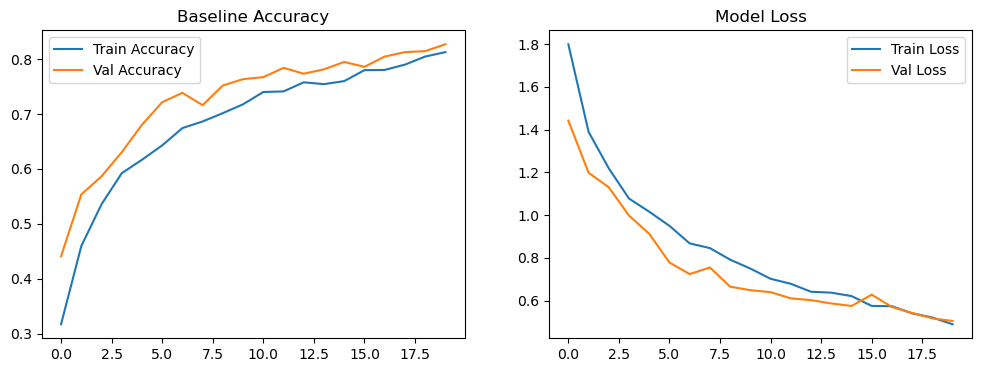

In [9]:
import matplotlib.pyplot as plt

# Create a figure with two plots
plt.figure(figsize=(12, 4))

# Plot Accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Baseline Accuracy')
plt.legend()

# Plot Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Model Loss')
plt.legend()

plt.show()

In [10]:
import numpy as np
from sklearn.model_selection import train_test_split

# 1. Ensure your data is loaded (using the files from your earlier steps)
X = np.load('X.npy')
y = np.load('y.npy')

# 2. Perform the split to create X_test and y_test (Crucial for Week 5-6)
# This splits 80% for training/validation and 20% for the final test
X_train_full, X_test, y_train_full, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 3. Normalize X_test if you haven't already
X_test = X_test.astype('float32') / 255.0
if len(X_test.shape) == 3:
    X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], X_test.shape[2], 1)

# 4. Predict on a single sample from your new X_test
sample_idx = 0 
sample_input = X_test[sample_idx:sample_idx+1] 
prediction = model.predict(sample_input)

# 5. Display results using your label_map
print("--- Analysis Results ---")
family_names = ['Bass', 'Brass', 'Flute', 'Guitar', 'Keyboard', 'Mallet', 'Organ', 'Reed', 'String', 'Synth', 'Vocal']
for i, prob in enumerate(prediction[0]):
    instrument_name = family_names[i]
    print(f"{instrument_name}: {prob*100:.2f}%")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 379ms/step
--- Analysis Results ---
Bass: 0.23%
Brass: 0.07%
Flute: 14.69%
Guitar: 1.93%
Keyboard: 7.44%
Mallet: 0.12%
Organ: 75.53%
Reed: 0.00%


Classes found in data: 8
Names being used: ['Bass', 'Brass', 'Flute', 'Guitar', 'Keyboard', 'Mallet', 'Organ', 'Reed']

  CLASSIFICATION REPORT
              precision    recall  f1-score   support

        Bass       0.86      0.92      0.89       159
       Brass       0.82      0.86      0.84       141
       Flute       0.76      0.78      0.77       138
      Guitar       0.87      0.77      0.82       150
    Keyboard       0.73      0.74      0.73       121
      Mallet       0.74      0.65      0.69       136
       Organ       0.82      0.87      0.84       135
        Reed       0.99      0.99      0.99       140

    accuracy                           0.83      1120
   macro avg       0.82      0.82      0.82      1120
weighted avg       0.83      0.83      0.83      1120



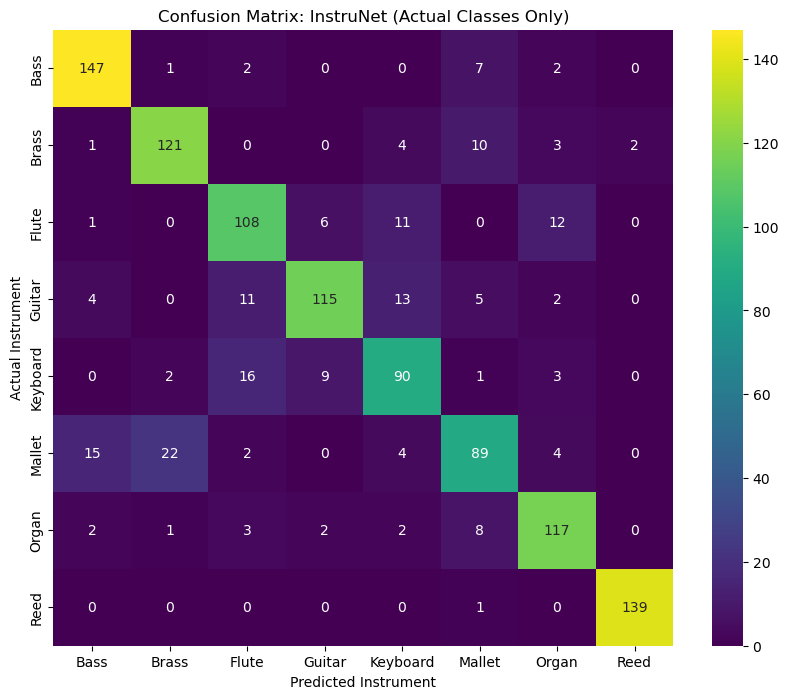

In [12]:
# 1. Find which class IDs (0-10) actually exist in your validation set
unique_classes = np.unique(y_true) 

# 2. Filter your family_names list to match only those IDs
# This will pick exactly the 8 names the error is looking for
filtered_names = [family_names[i] for i in unique_classes]

print(f"Classes found in data: {len(unique_classes)}")
print(f"Names being used: {filtered_names}")

# 3. Now run the report and confusion matrix
print("\n" + "="*30)
print("  CLASSIFICATION REPORT")
print("="*30)
print(classification_report(y_true, y_pred, target_names=filtered_names))

# 4. Plot the Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='viridis', 
            xticklabels=filtered_names, 
            yticklabels=filtered_names)

plt.title('Confusion Matrix: InstruNet (Actual Classes Only)')
plt.ylabel('Actual Instrument')
plt.xlabel('Predicted Instrument')
plt.show()